# Practical 4

In [1]:
import numpy as np
import cvxopt
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier

## Task 0: The Data

We will work with the data from practical 3. Load the data and split it into a training and test set. You can re-use the data splitting function from Practical 2.

In [2]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # ---------------- INSERT CODE ----------------------
    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)
    
    n_train = round(frac * X.shape[0])
    n_test = X.shape[0] - n_train
    
    # using the first n_train shuffled indexes for the training set
    # and the following observations for the training set
    idx_train = idx_shuffled[:n_train]
    idx_test = idx_shuffled[n_train:n_train + n_test]
    
    X_train = X[idx_train,:]
    X_test = X[idx_test,:]
    
    y_train = y[idx_train]
    y_test = y[idx_test]
    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test

In [3]:
# load data
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:,:2], np.load('data/nonlin_2d_data.npy')[:, 2]

In [4]:
# split data
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=2)

## Task 1: Support Vector Machines

First, you will implement a training algorithm for the Support Vector Machine (SVM). For solving the quadratic program, we provide a simple interface to the cvxopt library below.

In SVMs, each data sample $x_n$ has a corresponding lagrange multiplier $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha + \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ and $h$ are vectors with one element per individual constraint.

Having trained the SVM, a prediction for an input $\mathbf{x}$ is made by:

$$ y = sign([\sum_n^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n)] + b)  $$


### Task 1.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver. Fit a SVM on the training data and extract its parameters.

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.

In [5]:
def rbf_kernel(x_n, x_m, gamma=5):
    # returns the rbf kernel for two samples.
    aux = x_n - x_m
    kern = np.exp(- gamma * np.matmul(aux.T,aux))
    return kern

def linear_kernel(x_n, x_m):
    # return the linear kernel for two samples.
    kern = np.dot(x_m,x_n)
    return kern

In [6]:
def fit_svm(X, t, kernel, C=1.0):
    '''Fit SVM using data (X,t), specified kernel and parameter C.'''

    n_samples = X.shape[0]
    
    t = np.array([-1 if l == 0 else 1 for l in t])
    
    K = np.ones((len(X),len(X)))
    for jj in range(len(X)):
        for ii in range(len(X)):
            K[jj,ii] = kernel(X[jj,:],X[ii,:])
    T = np.diag(t)
    
    P = T @ K @ T
    q = np.ones(len(X)) * (-1)
    
    A = np.ones((1,len(t)))
    for jj in range(len(t)):
        A[0,jj] = float(t[jj])
    b = np.array([0.]).reshape((1,1)) 
    
    aux = np.array([-1,1])
    aux2 = np.identity(len(X))
    G = np.kron(aux2,aux).T
    
    aux3 = np.array([0,C])
    h = np.tile(aux3,len(X))

    assert P.shape == (len(X), len(X))
    assert len(q) == len(X)
    assert A.shape == (1, n_samples) and A.dtype == 'float'
    assert b.shape == (1, 1)
    assert len(G) == 2 * n_samples
    assert len(h) == 2 * len(X)

    return solve_quadratic_program(P, q, A, b, G, h)

def solve_quadratic_program(P, q, A, b, G, h):
    '''Uses cvxopt to solve the quadratic program.'''
    P, q, A, b, G, h = [cvxopt.matrix(var) for var in [P, q, A, b, G, h]]
    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
    lagr_mult = np.ravel(minimization['x'])
    return lagr_mult


def extract_parameters(X, t, kernel, lagr_mult, C,thresh = 1e-7):
    '''Computes the intercept from the support vector constraints.
    
    Inputs
        X:         predictors
        t:         targets
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        threshold: threshold for choosing support vectors
    
    Returns
        lagr_mult: lagrange multipliers for the support vectors
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept
    '''
    t = np.array([-1 if l == 0 else 1 for l in t])
    
    # ---------------- INSERT CODE ----------------------
    svs_ind = (thresh < lagr_mult) & (lagr_mult < C - thresh)
    svs = X[svs_ind]
    sv_labels = t[svs_ind]
    lagr_mult = lagr_mult[svs_ind]
    
    K = np.ones((len(svs),len(svs)))
    for jj in range(len(svs)):
        for ii in range(len(svs)):
            K[jj,ii] = kernel(svs[jj,:],svs[ii,:])
    
    n_svs = len(svs)
    sum_t = sv_labels.sum()
    sum_atk = 0
    for n in range(n_svs):
        for m in range(n_svs):
            aux = lagr_mult[m] * sv_labels[m] * K[m,n]
            sum_atk += aux
    
    intercept = 1/n_svs * sum_t - 1/n_svs * sum_atk

    # ---------------- END CODE -------------------------

    return lagr_mult, svs, sv_labels, intercept


In [7]:
# Fit SVM on training data
svm_out = fit_svm(X_train,t_train,rbf_kernel, C = 1.0)

# Extract parameters
lagr_mult, svs, sv_labels, intercept = extract_parameters(X_train, t_train, svm_out, rbf_kernel, C = 1.0, thresh=1e-7)

     pcost       dcost       gap    pres   dres
 0: -1.0260e+01 -1.0657e+02  1e+02  6e-17  6e-16
 1: -1.1157e+01 -1.6584e+01  5e+00  3e-16  4e-16
 2: -1.1564e+01 -1.2493e+01  9e-01  3e-16  3e-16
 3: -1.1685e+01 -1.1891e+01  2e-01  8e-16  2e-16
 4: -1.1721e+01 -1.1757e+01  4e-02  2e-16  2e-16
 5: -1.1730e+01 -1.1733e+01  3e-03  1e-15  2e-16
 6: -1.1730e+01 -1.1730e+01  8e-05  2e-16  2e-16
 7: -1.1730e+01 -1.1730e+01  2e-06  7e-16  2e-16
Optimal solution found.


TypeError: '<' not supported between instances of 'float' and 'function'

### Task 1.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function with your Gaussian RBF kernel (Practical 3) and compute the test accuracy on the 2d dataset.

In [ ]:
def svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept):
    
    # ---------------- INSERT CODE ----------------------



    # ---------------- END CODE -------------------------
    
    return prediction

In [ ]:
# Calculate test accuracy
b = np.array([0]).reshape((1,1)) 
type(b)
b.shape

### Task 1.3

- Instead of using the Gaussian RBF kernel, use the linear kernel (dot product) defined in Practical 3.
- Compare results on with both kernels with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary for both kernels.

In [ ]:
def linear_kernel(a, b):
    pass

In [ ]:
# Fit SVM with linear kernel and calculate the test accuracy


In [ ]:
# Fit SVM using sklearn and calculate the test accuracy


In [ ]:
# Visualize


# Task 2: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples, i.e. between `t[:50]` and `t[50:]`.

In [8]:
# Load Wine dataset and split into train+test set

X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X, t)

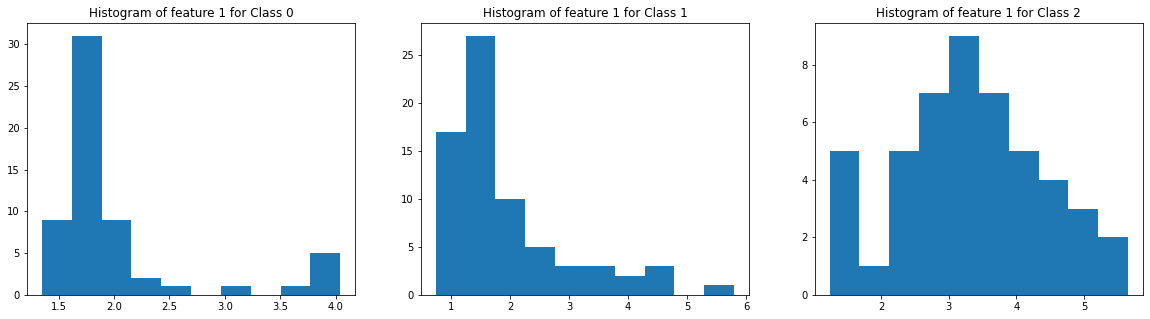

In [9]:
# Plot distribution
fig, ax = plt.subplots(1,3,figsize = (20,5))

for jj in range(3):
    ax[jj].hist(X[t == jj,1])
    ax[jj].set_title("Histogram of feature 1 for Class "+str(jj))

In [10]:
# Compute Gini impurity
def gini_impurity(t):
    """function to calculate the gini impurity"""
    # first get the number of observations in each class
    classes = np.unique(t)
    class_obs = np.ones(len(classes))
    for jj in range(len(class_obs)):
        class_obs[jj] = len(t[t == classes[jj]])
    n = len(t)
    
    # calculate the probabilities of each class
    probs = np.ones(len(classes))
    for jj in range(len(probs)):
        probs[jj] = class_obs[jj]/n
    
    # calculate the gini impurity
    impu = np.ones(len(classes))
    for jj in range(len(classes)):
        impu = probs[jj] * (1-probs[jj])
    
    gini = impu.sum()
    
    return gini

In [11]:
# split after 50 samples:
gini_before = gini_impurity(t)
gini_after = len(t[:50])/len(t) * gini_impurity(t[:50]) + len(t[50:])/len(t) * gini_impurity(t[50:])

reduced_gini = gini_before - gini_after
print("The removed gini based on a split after 50 samples is:",reduced_gini)
print("\n")
print("gini before:", gini_before)
print("gini after:", gini_after)


The removed gini based on a split after 50 samples is: 0.028405504355510675


gini before: 0.1969448301982073
gini after: 0.16853932584269662


### Task 2.2
Split the data along the first 12 features and plot the removed Gini impurity at different values of this feature. Which is the optimal split?

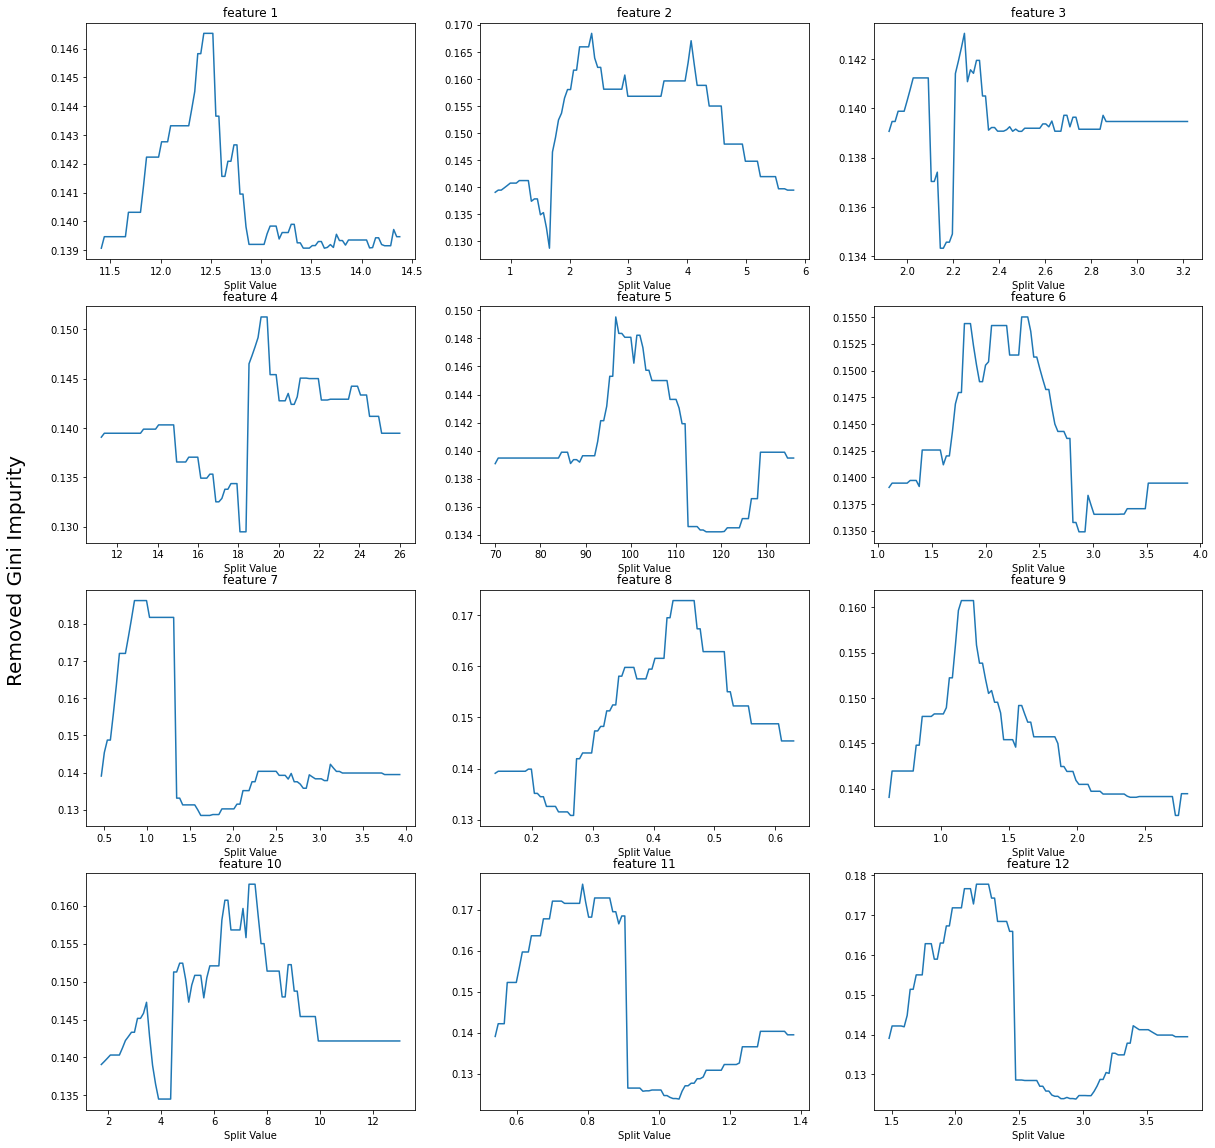

In [12]:
# Plotting

gini_reduc = np.ones((100,12))
thresholds = np.ones((100,12))
for jj in range(12):
    feat = X_train[:,jj]
    var_min = feat.min()
    var_max = feat.max()
    seq = np.linspace(var_min,var_max,100)
    thresholds[:,jj] = seq
    for ii in range(len(seq)):        
        t_0 = t_train[feat < seq[ii]]
        t_1 = t_train[feat >= seq[ii]]
        gini_before = gini_impurity(t)
        gini_after = len(t_0)/len(t) * gini_impurity(t_0) + len(t_1)/len(t) * gini_impurity(t_1)
        gini_reduc[ii,jj] = gini_before - gini_after

fig, ax = plt.subplots(4,3,figsize = (20,20))

fig.text(0.07, .5,"Removed Gini Impurity", fontsize = 20,va='center', rotation='vertical')
count = 0
for jj in range(4):
    for ii in range(3):
        ax[jj,ii].plot(thresholds[:,count],gini_reduc[:,count])
        ax[jj,ii].set_title("feature " + str(count+1))
        ax[jj,ii].set_xlabel("Split Value")
        count += 1 

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [13]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold

class Leaf:
    def __init__(self, label):
        self.label = label


In [14]:
# Implement recursive tree function

def get_best_split(X,t,n_vals = 20):
    n_feat = X.shape[1]
    n_obs = len(X)
    
    gini_reduc = np.ones((n_vals,n_feat))
    thresholds = np.ones((n_vals,n_feat))
    
    # first create a sequence of values to try for each variable and store in thresholds
    for jj in range(n_feat):
        feat = X[:,jj]
        feat_min = feat.min()
        feat_max = feat.max()
        thresholds[:,jj] = np.linspace(feat_min,feat_max,n_vals)

    # For each feature and for each threshold calculate the gini reduction
    for jj in range(n_feat):
        feat = X[:,jj]
        thresh = thresholds[:,jj]
        for ii in range(len(thresh)):        
            t_left = t[feat < thresh[ii]]
            t_right = t[feat >= thresh[ii]]
            gini_before = gini_impurity(t)
            gini_after = len(t_left)/len(t) * gini_impurity(t_left) + len(t_right)/len(t) * gini_impurity(t_right)
            gini_reduc[ii,jj] = gini_before - gini_after
    
    # get j and s for the maximum gini reduction
    # if there is no unique maximum, select the first.
    # i is the row index for the threshold matrix
    
    max_reduc = gini_reduc.max()
    which_max = np.where(gini_reduc == max_reduc)
    
    j = int(which_max[1][0])
    i = int(which_max[0][0])
    s = thresholds[i,j]
    
    return j,s,max_reduc

def partition(X,t,j,s):
    left = t[X[:,j] < s], X[X[:,j] < s,:]
    right = t[X[:,j] >= s], X[X[:,j] >= s,:]
    
    return left, right

def create_leaf(t):
    # here t refers to an array of observations (only targets) in a terminal node
    labels = np.unique(t)
    freq = np.ones(len(labels))
    for jj in range(len(freq)):
        freq[jj] = len(t[t == labels[jj]])/len(t)
    most_frequent_label = labels[np.where(freq == freq.max())[0]]
    Lf = Leaf(most_frequent_label)
    return Lf 

    
def build_tree(X, t, depth, max_depth=3):
    
    # ---------------- INSERT CODE ----------------------
    
    # start by splitting the full data
    j,s,gain = get_best_split(X,t)
    
    # check whether gain is greater than zero
    # if gain is equal to zero, just return a leaf
    if gain == 0 or depth == max_depth:
        return create_leaf(t)    
    
    # if we reach here, gain is greater than zero (i.e. we found a sensible split)
    # thus split the data
    left, right = partition(X,t,j,s)
    
    # recursively build the left side of the node
    left_branch = build_tree(X = left[1], t = left[0],depth = depth + 1, max_depth = max_depth)
    
    # recursively build the right side of the node
    right_branch = build_tree(X = right[1], t = right[0], depth = depth + 1, max_depth = max_depth)
    
    # return the node
    return Node(left = left_branch,right = right_branch,n_feat = j, threshold = s)
   
    # ---------------- END CODE -------------------------

    
def predict_tree(node, x):
    # ---------------- INSERT CODE ----------------------
    if isinstance(node,Leaf):
        return node.label
    
    if x[node.n_feat] < node.threshold:
        return predict_tree(node.left,x)
    else: 
        return predict_tree(node.right,x)
    # ---------------- END CODE -------------------------

In [15]:
# Build tree
tree = build_tree(X_train, t_train, 0, max_depth=3)

In [16]:
# Calculate training and test scores
def get_score(preds,t):
    aux = preds == t
    score = aux.sum()/len(aux)
    return(score)

def predict_matrix(tree,X):
    preds = np.empty(len(X))
    for jj in range(len(X)):
        preds[jj] = predict_tree(tree,X[jj,:])
    return preds

pred_train = predict_matrix(tree,X_train)
pred_test = predict_matrix(tree,X_test)
    
score_train = get_score(pred_train,t_train)
score_test = get_score(pred_test,t_test)

print("training sample accuracy:",round(score_train,3))
print("test sample accuracy:",round(score_test, 3))

training sample accuracy: 0.925
test sample accuracy: 0.896


In [17]:
# Calculate test score using sklearn
tree_sklearn = DecisionTreeClassifier(random_state = 0, max_depth = 3).fit(X = X_train, y = t_train)
score_train_skl = tree_sklearn.score(X_train,t_train)
score_test_skl = tree_sklearn.score(X_test,t_test)

print("Sklearn accuracy on training data", score_train_skl)
print("Sklearn accuracy on test data", score_test_skl)

Sklearn accuracy on training data 1.0
Sklearn accuracy on test data 0.896


In [18]:
# Calculate test score for synthetic 2D dataset
X_train_2d, X_test_2d, t_train_2d, t_test_2d = split_data(X_2d, t_2d, seed=2)

tree_2d = build_tree(X_train_2d,t_train_2d,0,max_depth = 3)

pred_train_2d = predict_matrix(tree_2d,X_train_2d)
score_train_2d = get_score(pred_train_2d,t_train_2d)

pred_test_2d = predict_matrix(tree_2d,X_test_2d)
score_test_2d = get_score(pred_test_2d,t_test_2d)

tree_2d_skl = DecisionTreeClassifier(random_state = 0, max_depth = 3).fit(X = X_train_2d, y = t_train_2d)
score_train_2d_skl = tree_2d_skl.score(X_train_2d,t_train_2d)
score_test_2d_skl = tree_2d_skl.score(X_test_2d,t_test_2d)

print("Own implementation training accuracy:",score_train_2d)
print("Own implementation test accruracy:",score_test_2d)
print("\n")
print("Sklearn accuracy on training data", score_train_2d_skl)
print("Sklearn accuracy on test data", score_test_2d_skl)

Own implementation training accuracy: 0.9466666666666667
Own implementation test accruracy: 0.9085714285714286


Sklearn accuracy on training data 0.9333333333333333
Sklearn accuracy on test data 0.88


In [19]:
# Visualize
# define a function to print the tree
def print_tree(node,spacing = ""):
    
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.label)
        return
    
    # if we haven't reached a leaf, we end up here
    # Print the split argument at the node
    print("Feature",node.n_feat + 1,">=",round(node.threshold,2),"?")

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.right, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.left, spacing + "  ")

print_tree(tree)

Feature 7 >= 0.83 ?
--> True:
Feature 11 >= 0.61 ?
  --> True:
Feature 1 >= 12.82 ?
    --> True:
      Predict [0]
    --> False:
      Predict [1]
  --> False:
    Predict [2]
--> False:
  Predict [2]
